## Data

### The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels dowloaded from Kaggle.


In [64]:
# Install necessary libraries 
!pip install transformers torch
!pip install accelerate

In [88]:
# Suppress warning messages for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix   
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TF-IDF Vectorizer
from sklearn.model_selection import train_test_split  # Import for train-test split


In [66]:
# Load the data
data = pd.read_csv('data.csv')  # Load the dataset
print(data.head())  # Display the first few rows of the DataFrame
print(data.info())  # Display information about the DataFrame
print("Shape of data:", data.shape)  # Check the shape of the data
print("Columns in data:", data.columns)  # Identify the columns

                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None
Shape of data: (5842, 2)
Columns in data: Index(['Sentence', 'Sentiment'], dtype='object')


In [67]:
# Check the values of 'Sentiment'
print("Sentiment value counts:\n", data['Sentiment'].value_counts())

Sentiment value counts:
 neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


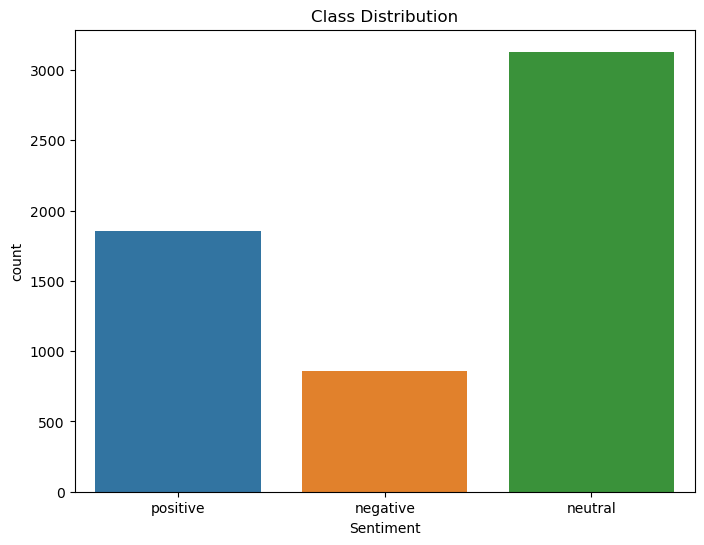

In [68]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data)
plt.title('Class Distribution')
plt.show()

### we can see a high class imbalance with negative sentiment below 1000 count and neutral above 3000 count . we will adopt class_weghts to address this issue

In [70]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [71]:
# Initialize the lemmatizer and set of stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(sentence):
    tokens = word_tokenize(sentence)
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens]  # Remove punctuation
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if len(word) > 2]  # Lemmatize and filter short words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Apply preprocessing to the 'Sentence' column
data["Tokens_lemmatized"] = data["Sentence"].apply(preprocess_text)
data['Processed_Sentence'] = data['Tokens_lemmatized'].apply(lambda x: ' '.join(x))

In [108]:
# Prepare features and labels

y = pd.factorize(data['Sentiment'])[0]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [73]:
print(X_train.isnull().sum())  # Count NaN values

0


In [74]:
import numpy as np

# Check for NaN values in y_train
nan_count = np.sum(np.isnan(y_train))
print(f"Number of NaN values in y_train: {nan_count}")


# Check the unique classes and their counts
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:", class_distribution)

Number of NaN values in y_train: 0
Class Distribution: {0: 1480, 1: 685, 2: 2508}


In [75]:
print(type(y_train))
print(y_train[:10])  # Check the first few values

<class 'numpy.ndarray'>
[2 2 0 2 0 2 2 2 1 2]


In [76]:
print(len(X_train), len(y_train))  # Should be equal

4673 4673


In [77]:
X_train = X_train.astype(str) # to avoid mix data and ensure all is string this will help in vectorization

In [79]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)

# Check the shapes of the train and validation sets
print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train_final shape: (3738, 9976)
y_train_final shape: (3738,)
X_val shape: (935, 9976)
y_val shape: (935,)


In [112]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

XGBoost Model Performance:
Accuracy: 0.6655260906757913
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       372
           1       0.33      0.38      0.35       175
           2       0.73      0.76      0.74       622

    accuracy                           0.67      1169
   macro avg       0.60      0.59      0.60      1169
weighted avg       0.67      0.67      0.67      1169



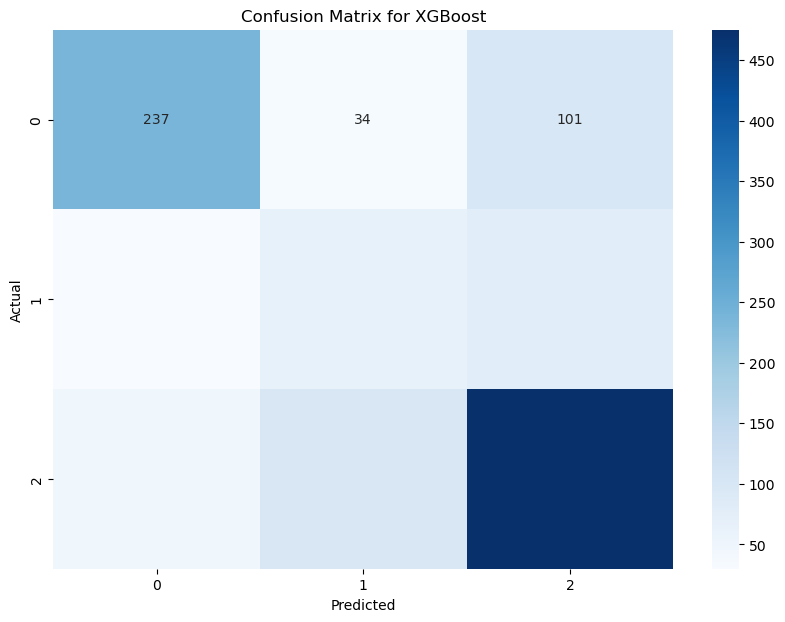

Misclassified Samples for XGBoost:
      Actual  Predicted                                           Sentence
4678       1          0  peer peugeot fell 081 pct sale rose pct period...
2534       0          2  vaisala group successful international technol...
1501       1          2    new credit suisse bos face stiff challenge asia
1514       0          2  update 1berkshire applies boost well fargo sta...
2664       2          1  operating loss totalled eur profit eur first h...


In [114]:

# Train XGBoost Model with class weights
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_tfidf, y_train, sample_weight=[class_weights_dict[cls] for cls in y_train])
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate the XGBoost model
print("XGBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Error Analysis for XGBoost
results_xgb = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_xgb,
    'Sentence': X_test
})
misclassified_xgb = results_xgb[results_xgb['Actual'] != results_xgb['Predicted']]
print("Misclassified Samples for XGBoost:")
print(misclassified_xgb.head())

Random Forest Model Performance:
Accuracy: 0.6501283147989735
              precision    recall  f1-score   support

           0       0.74      0.62      0.68       372
           1       0.24      0.17      0.20       175
           2       0.68      0.80      0.73       622

    accuracy                           0.65      1169
   macro avg       0.55      0.53      0.54      1169
weighted avg       0.63      0.65      0.64      1169



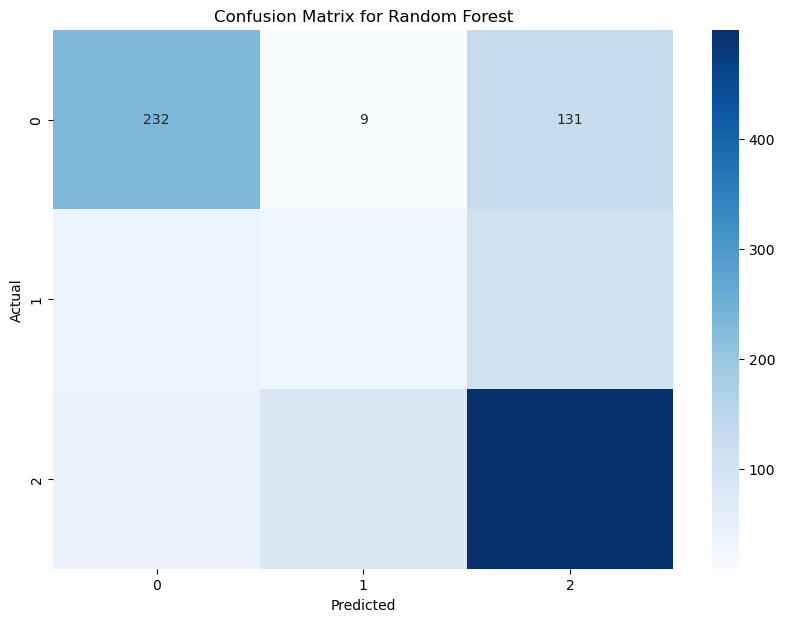

Misclassified Samples for Random Forest:
      Actual  Predicted                                           Sentence
4678       1          2  peer peugeot fell 081 pct sale rose pct period...
2534       0          2  vaisala group successful international technol...
1501       1          2    new credit suisse bos face stiff challenge asia
2664       2          0  operating loss totalled eur profit eur first h...
3612       2          0  line run fully underground comprise station ex...


In [116]:
# Train Random Forest Model with class weights
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights_dict)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the Random Forest model
print("Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Error Analysis for Random Forest
results_rf = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rf,
    'Sentence': X_test
})
misclassified_rf = results_rf[results_rf['Actual'] != results_rf['Predicted']]
print("Misclassified Samples for Random Forest:")
print(misclassified_rf.head())

### Model Performance: The XGBoost model outperforms Random Forest in terms of accuracy, precision, and recall, particularly for class 1.

### I will now use a pretrained model from transformers to compare > BERT model 

In [118]:
# Define the dataset class for sentiment analysis
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add label tensor
        return item

    def __len__(self):
        return len(self.labels)

# Load and prepare data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Create dataset instances for training and testing
train_dataset = SentimentDataset(train_encodings, y_train)  # For training data
test_dataset = SentimentDataset(test_encodings, y_test)  # For testing data

# Suppress specific warnings about parameter name changes
warnings.filterwarnings("ignore", message="A parameter name that contains `beta` will be renamed internally to `bias`")
warnings.filterwarnings("ignore", message="A parameter name that contains `gamma` will be renamed internally to `weight`")

# Load a pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)))

# Set up training arguments for the Trainer
training_args = TrainingArguments(
    output_dir='./results',  # Directory for saving model outputs
    num_train_epochs=3,  # Number of epochs for training
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=8,  # Batch size for evaluation
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Weight decay for regularization
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Frequency of logging training progress
)

# Create a Trainer instance for managing the training process
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
evaluation_results = trainer.evaluate()

# Get predictions from the model
predictions = trainer.predict(test_dataset)

# Extract predicted labels from the predictions
predicted_labels = predictions.predictions.argmax(axis=-1)  # Get the index of the highest score
true_labels = predictions.label_ids  # True labels from the test set

# Calculate accuracy of the model
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy

# Optional: Print a detailed classification report
print(classification_report(true_labels, predicted_labels))  # Show precision, recall, and F1 score

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Step,Training Loss
10,1.159400
20,1.157200
30,1.140600
40,1.107900
50,1.038400
60,1.012200
70,0.942700
80,0.973600
90,0.962600
100,0.986700


Accuracy: 0.7690
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       372
           1       0.49      0.46      0.48       175
           2       0.81      0.82      0.81       622

    accuracy                           0.77      1169
   macro avg       0.71      0.70      0.71      1169
weighted avg       0.77      0.77      0.77      1169



### The BERT model achieved an accuracy of approximately 76.90% on the validation set, which suggests a decent level of performance